# Data Augmentation with Backcast Models

using saved backcast models for each longhurst region, perform predictions and add column to savoca dataset

## Import Libraries

In [1]:
import os
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from pprint import pprint
from datetime import date, timedelta, datetime
import requests
import xarray as xr
import rioxarray
from shapely.geometry import mapping

import earthaccess

### Load Savoca Dataset

In [2]:
# get the number of columns in the csv file
with open('../agg_data_cleaned.csv') as x:
    ncols = len(x.readline().split(','))
    
# load in the data skipping the first empty column
df = pd.read_csv('../agg_data_cleaned.csv',usecols=range(1,ncols))
df

,Scientific name,Common name,Order,Family,Trophic level,Num. w plastic,Total num. sampled,FO of plastic,Mean num particles per indv,Habitat,...,parsed_date,Risk_0_3,Risk_0_5,Risk_0_10,Risk_0pt5_5,Risk_0pt5_10,Risk_1_5,Risk_1_10,Risk_3_10,Risk_5_10
0,Platicephalus indicus,Bartail flathead,Scorpaeniformes,Platycephalidae,3.6,8.0,12.0,0.666667,2.300000,reef-associated,...,"(Timestamp('2015-01-01 00:00:00'), Timestamp('...",1,1,1,1,1,1,1,0,0
1,Saurida tumbil,Greater lizardfish,Aulopiformes,Synodontidae,4.4,4.0,4.0,1.000000,2.800000,reef-associated,...,"(Timestamp('2015-01-01 00:00:00'), Timestamp('...",1,1,1,1,1,1,1,0,0
2,Sillago sihama,Silver sillago,Perciformes,Sillaginidae,3.3,17.0,17.0,1.000000,1.500000,reef-associated,...,"(Timestamp('2015-01-01 00:00:00'), Timestamp('...",1,1,1,1,1,1,1,0,0
3,Cynoglossus abbreviatus,Three-lined tounge sole,Pleuronectiformes,Cynoglossidae,3.5,11.0,11.0,1.000000,2.900000,demersal,...,"(Timestamp('2015-01-01 00:00:00'), Timestamp('...",1,1,1,1,1,1,1,0,0
4,Galeus melastomus,Blackmouth catshark,Carcharhiniformes,Scyliorhinidae,4.2,21.0,125.0,0.168000,0.057120,demersal,...,"(Timestamp('2006-01-01 00:00:00'), Timestamp('...",1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,Coryphaena hippurus,Common dolphinfish,Perciformes,Coryphaenidae,4.4,20.0,2219.0,0.009013,0.015773,pelagic-neritic,...,"(Timestamp('1980-01-01 00:00:00'), Timestamp('...",1,1,1,0,0,0,0,0,0
797,Prionace glauca,Blue shark,Carcharhiniformes,Carcharhinidae,4.4,29.0,893.0,0.032475,0.035800,pelagic-oceanic,...,"(Timestamp('1995-01-01 00:00:00'), Timestamp('...",1,1,1,0,0,0,0,0,0
798,Coryphaena hippurus,Common dolphinfish,Perciformes,Coryphaenidae,4.4,1.0,1.0,1.000000,1.000000,pelagic-oceanic,...,"(Timestamp('2011-07-01 00:00:00'), Timestamp('...",1,1,1,1,1,0,0,0,0
799,Thunnus alalunga,Albacore tuna,Perciformes,Scombridae,4.3,1.0,2.0,0.500000,NaN,pelagic-oceanic,...,NaN,2,2,2,2,2,2,2,2,2


### Subset to Quantified MPs

In [3]:
# df = df[df['Quantified microplastic'] == 'Y']
df = df.dropna(axis=0)
df

,Scientific name,Common name,Order,Family,Trophic level,Num. w plastic,Total num. sampled,FO of plastic,Mean num particles per indv,Habitat,...,parsed_date,Risk_0_3,Risk_0_5,Risk_0_10,Risk_0pt5_5,Risk_0pt5_10,Risk_1_5,Risk_1_10,Risk_3_10,Risk_5_10
0,Platicephalus indicus,Bartail flathead,Scorpaeniformes,Platycephalidae,3.6,8.0,12.0,0.666667,2.30000,reef-associated,...,"(Timestamp('2015-01-01 00:00:00'), Timestamp('...",1,1,1,1,1,1,1,0,0
1,Saurida tumbil,Greater lizardfish,Aulopiformes,Synodontidae,4.4,4.0,4.0,1.000000,2.80000,reef-associated,...,"(Timestamp('2015-01-01 00:00:00'), Timestamp('...",1,1,1,1,1,1,1,0,0
2,Sillago sihama,Silver sillago,Perciformes,Sillaginidae,3.3,17.0,17.0,1.000000,1.50000,reef-associated,...,"(Timestamp('2015-01-01 00:00:00'), Timestamp('...",1,1,1,1,1,1,1,0,0
3,Cynoglossus abbreviatus,Three-lined tounge sole,Pleuronectiformes,Cynoglossidae,3.5,11.0,11.0,1.000000,2.90000,demersal,...,"(Timestamp('2015-01-01 00:00:00'), Timestamp('...",1,1,1,1,1,1,1,0,0
4,Galeus melastomus,Blackmouth catshark,Carcharhiniformes,Scyliorhinidae,4.2,21.0,125.0,0.168000,0.05712,demersal,...,"(Timestamp('2006-01-01 00:00:00'), Timestamp('...",1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
680,Centroberyx lineatus,Swallow-tail,Beryciformes,Berycidae,4.2,3.0,3.0,1.000000,2.83000,benthopelagic,...,"(Timestamp('2017-03-01 00:00:00'), Timestamp('...",1,1,1,1,1,1,1,0,0
681,Chlorophthalmus agassizi,Shortnose greeneye,Aulopiformes,Chlorophthalmidae,3.7,1.0,1.0,1.000000,1.88000,bathydemersal,...,"(Timestamp('2017-03-01 00:00:00'), Timestamp('...",1,1,1,1,1,1,1,0,0
686,Neoscopelus microchir,shortfin neoscopelid,Myctophiformes,Neoscopelidae,3.2,1.0,1.0,1.000000,3.78000,bathypelagic,...,"(Timestamp('2017-03-01 00:00:00'), Timestamp('...",2,1,1,1,1,1,1,1,0
688,Rexea solandri,Silver gemfish,Perciformes,Gempylidae,4.3,3.0,3.0,1.000000,4.40000,benthopelagic,...,"(Timestamp('2017-03-01 00:00:00'), Timestamp('...",2,1,1,1,1,1,1,1,0


### Load Longhurst Region Shapes

In [4]:
longhurst = gpd.read_file('../Savoca/Longhurst_world_v4_2010.shp')

In [5]:
longhurst

,ProvCode,ProvDescr,geometry
0,BPLR,Polar - Boreal Polar Province (POLR),"MULTIPOLYGON (((-161.184 63.500, -161.500 63.5..."
1,ARCT,Polar - Atlantic Arctic Province,"MULTIPOLYGON (((-21.513 64.644, -21.559 64.641..."
2,SARC,Polar - Atlantic Subarctic Province,"MULTIPOLYGON (((11.265 63.961, 11.095 63.886, ..."
3,NADR,Westerlies - N. Atlantic Drift Province (WWDR),"POLYGON ((-11.500 57.500, -11.500 56.500, -11...."
4,GFST,Westerlies - Gulf Stream Province,"POLYGON ((-43.500 43.500, -43.500 42.500, -43...."
5,NASW,Westerlies - N. Atlantic Subtropical Gyral Pro...,"POLYGON ((-39.500 25.500, -40.500 25.500, -41...."
6,NATR,Trades - N. Atlantic Tropical Gyral Province (...,"MULTIPOLYGON (((-72.347 18.536, -72.369 18.526..."
7,WTRA,Trades - Western Tropical Atlantic Province,"POLYGON ((-19.500 -6.500, -20.500 -6.500, -21...."
8,ETRA,Trades - Eastern Tropical Atlantic Province,"POLYGON ((9.500 -12.500, 8.500 -12.500, 7.500 ..."
9,SATL,Trades - South Atlantic Gyral Province (SATG),"POLYGON ((-19.500 -6.500, -18.500 -6.500, -17...."


### Load in Saved Models

In [6]:
with open('model_dict2.pkl','rb') as f:
    model_dict = pickle.load(f)

In [7]:
model_dict

{'GFST': <prophet.forecaster.Prophet at 0x10501bbe0>,
 'NASW': <prophet.forecaster.Prophet at 0x30732f640>,
 'NATR': <prophet.forecaster.Prophet at 0x307364520>,
 'WTRA': <prophet.forecaster.Prophet at 0x3073656c0>,
 'ETRA': <prophet.forecaster.Prophet at 0x307366860>,
 'SATL': <prophet.forecaster.Prophet at 0x307367a00>,
 'CNRY': <prophet.forecaster.Prophet at 0x30729cbe0>,
 'GUIN': <prophet.forecaster.Prophet at 0x30729dd80>,
 'GUIA': <prophet.forecaster.Prophet at 0x30729ef20>,
 'NWCS': <prophet.forecaster.Prophet at 0x306e20100>,
 'MEDI': <prophet.forecaster.Prophet at 0x306e212a0>,
 'CARB': <prophet.forecaster.Prophet at 0x306e22440>,
 'NASE': <prophet.forecaster.Prophet at 0x306e235e0>,
 'BRAZ': <prophet.forecaster.Prophet at 0x306ee87c0>,
 'BENG': <prophet.forecaster.Prophet at 0x306ee9960>,
 'MONS': <prophet.forecaster.Prophet at 0x306eeab00>,
 'ISSG': <prophet.forecaster.Prophet at 0x306eebca0>,
 'EAFR': <prophet.forecaster.Prophet at 0x307488e80>,
 'REDS': <prophet.forecaster

### Augment Savoca Dataset

In [8]:
# define list of provinces with models for augmenting savoca data
cygnss_provs_list = list(model_dict.keys())

# define cygnss dataset for specified provinces
cygnss_df = df[df['Oceanographic province'].isin(cygnss_provs_list)]

# get cygnss provs dataframe with polygons
cygnss_provs = longhurst[longhurst['ProvCode'].isin(cygnss_provs_list)]

In [9]:
# convert parsed date column from string to tuple of timestamps
def convertToStamp(datestr):
    # Extract the date strings using regular expressions
    date_strings = re.findall(r"Timestamp\('(.*?)'\)", datestr)

    # Convert the date strings to Timestamps
    start_date, end_date = pd.Timestamp(date_strings[0]), pd.Timestamp(date_strings[1])

    # Create the tuple
    date_tuple = (start_date, end_date)
    
    return date_tuple

cygnss_df['parsed_date'] = cygnss_df['parsed_date'].apply(convertToStamp)
cygnss_df

/var/folders/80/fylkxrjj1_gd5l1h_m8tkyc00000gn/T/ipykernel_11595/1589782442.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cygnss_df['parsed_date'] = cygnss_df['parsed_date'].apply(convertToStamp)


,Scientific name,Common name,Order,Family,Trophic level,Num. w plastic,Total num. sampled,FO of plastic,Mean num particles per indv,Habitat,...,parsed_date,Risk_0_3,Risk_0_5,Risk_0_10,Risk_0pt5_5,Risk_0pt5_10,Risk_1_5,Risk_1_10,Risk_3_10,Risk_5_10
0,Platicephalus indicus,Bartail flathead,Scorpaeniformes,Platycephalidae,3.6,8.0,12.0,0.666667,2.30000,reef-associated,...,"(2015-01-01 00:00:00, 2015-12-31 00:00:00)",1,1,1,1,1,1,1,0,0
1,Saurida tumbil,Greater lizardfish,Aulopiformes,Synodontidae,4.4,4.0,4.0,1.000000,2.80000,reef-associated,...,"(2015-01-01 00:00:00, 2015-12-31 00:00:00)",1,1,1,1,1,1,1,0,0
2,Sillago sihama,Silver sillago,Perciformes,Sillaginidae,3.3,17.0,17.0,1.000000,1.50000,reef-associated,...,"(2015-01-01 00:00:00, 2015-12-31 00:00:00)",1,1,1,1,1,1,1,0,0
3,Cynoglossus abbreviatus,Three-lined tounge sole,Pleuronectiformes,Cynoglossidae,3.5,11.0,11.0,1.000000,2.90000,demersal,...,"(2015-01-01 00:00:00, 2015-12-31 00:00:00)",1,1,1,1,1,1,1,0,0
4,Galeus melastomus,Blackmouth catshark,Carcharhiniformes,Scyliorhinidae,4.2,21.0,125.0,0.168000,0.05712,demersal,...,"(2006-01-01 00:00:00, 2006-12-31 00:00:00)",1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
680,Centroberyx lineatus,Swallow-tail,Beryciformes,Berycidae,4.2,3.0,3.0,1.000000,2.83000,benthopelagic,...,"(2017-03-01 00:00:00, 2017-03-31 00:00:00)",1,1,1,1,1,1,1,0,0
681,Chlorophthalmus agassizi,Shortnose greeneye,Aulopiformes,Chlorophthalmidae,3.7,1.0,1.0,1.000000,1.88000,bathydemersal,...,"(2017-03-01 00:00:00, 2017-03-31 00:00:00)",1,1,1,1,1,1,1,0,0
686,Neoscopelus microchir,shortfin neoscopelid,Myctophiformes,Neoscopelidae,3.2,1.0,1.0,1.000000,3.78000,bathypelagic,...,"(2017-03-01 00:00:00, 2017-03-31 00:00:00)",2,1,1,1,1,1,1,1,0
688,Rexea solandri,Silver gemfish,Perciformes,Gempylidae,4.3,3.0,3.0,1.000000,4.40000,benthopelagic,...,"(2017-03-01 00:00:00, 2017-03-31 00:00:00)",2,1,1,1,1,1,1,1,0


In [10]:
from shapely.geometry import box

def clip_geometry_latitudes(gdf, min_lat=-37, max_lat=37):
    """
    Clips the polygons in the 'geometry' column of a GeoDataFrame
    based on a latitude range.
    
    Parameters:
    - gdf: GeoDataFrame with a 'geometry' column containing polygons.
    - min_lat: The minimum latitude for clipping (default -37).
    - max_lat: The maximum latitude for clipping (default 37).
    
    Returns:
    - GeoDataFrame with modified geometries.
    """
    # Define a bounding box with the specified latitude limits and broad longitudes
    clipping_box = box(-180, min_lat, 180, max_lat)
    
    # Apply the intersection of each geometry with the clipping box
    gdf['geometry'] = gdf['geometry'].intersection(clipping_box)
    
    return gdf

# Example usage:
# Assuming your DataFrame is loaded as a GeoDataFrame named `gdf`
tmp = clip_geometry_latitudes(cygnss_provs)
tmp

/Users/ds/anaconda3/lib/python3.10/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,ProvCode,ProvDescr,geometry
4,GFST,Westerlies - Gulf Stream Province,"POLYGON ((-69.50000 36.50000, -69.50000 35.500..."
5,NASW,Westerlies - N. Atlantic Subtropical Gyral Pro...,"POLYGON ((-40.50000 25.50000, -41.50000 25.500..."
6,NATR,Trades - N. Atlantic Tropical Gyral Province (...,"MULTIPOLYGON (((-72.36877 18.52569, -72.39528 ..."
7,WTRA,Trades - Western Tropical Atlantic Province,"POLYGON ((-20.50000 -6.50000, -21.50000 -6.500..."
8,ETRA,Trades - Eastern Tropical Atlantic Province,"POLYGON ((8.50000 -12.50000, 7.50000 -12.50000..."
9,SATL,Trades - South Atlantic Gyral Province (SATG),"POLYGON ((-18.50000 -6.50000, -17.50000 -6.500..."
11,CNRY,Coastal - Canary Coastal Province (EACB),"MULTIPOLYGON (((-16.38454 11.50000, -16.36861 ..."
12,GUIN,Coastal - Guinea Current Coastal Province,"MULTIPOLYGON (((-15.42931 11.65458, -15.45549 ..."
13,GUIA,Coastal - Guianas Coastal Province,"MULTIPOLYGON (((-35.50000 -4.50000, -34.50000 ..."
14,NWCS,Coastal - NW Atlantic Shelves Province,"MULTIPOLYGON (((-82.50000 27.69510, -82.50000 ..."


/Users/ds/anaconda3/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<Axes: >

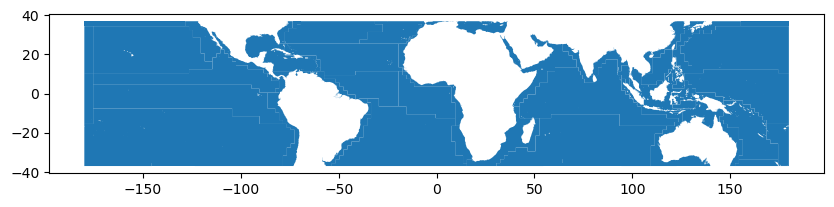

In [11]:
# quick look at the regions that have been defined including partial clipped regions
tmp.plot(figsize=(10,10))

In [12]:
# define function to apply to dataframe rows to generate MP Density Prediction
def predictMP(row):
    
    # get the longhurst region
    prov = row['Oceanographic province']
    
    # get the corresponding model
    m = model_df[prov]
    
    # get the date of the study
    ds = row['parsed_date']
    pd.DataFrame({'ds': ds})
    
    # predict MP density
#     m.

### Load Local Copy of CYGNSS Data

In [13]:
try:
    with open('mp_sat_data.pkl', 'rb') as f:
        cygnss_data = pickle.load(f)
except:
    data_folder = "/Volumes/samsung1TB/CYGNSS_L3_MICROPLASTIC_V3.2_3.2-20241028_073551/"
    satellite_files = os.listdir(data_folder)
    satellite_files = [data_folder + file for file in satellite_files if not file.startswith(".")]
    cygnss_data = xr.open_mfdataset(satellite_files)

### Convert CYGNSS Data to Proper Coordinate Reference System

In [14]:
mp_sat_data = cygnss_data

In [15]:
print(f"Latitude range: {mp_sat_data.lat.min().values} to {mp_sat_data.lat.max().values}")
print(f"Longitude range: {mp_sat_data.lon.min().values} to {mp_sat_data.lon.max().values}")

Latitude range: -37.0 to 37.0
Longitude range: -180.0 to 179.75


In [16]:
if mp_sat_data.rio.crs is not None:
    print(f"Dataset CRS: {mp_sat_data.rio.crs}")
else:
    print("Dataset CRS is not set.")

Dataset CRS: EPSG:4326


In [17]:
mp_sat_data = mp_sat_data.rio.write_crs("EPSG:4326", inplace=True)
mp_sat_data = mp_sat_data.assign_coords(lon=(((mp_sat_data.lon + 180) % 360) - 180)).sortby('lon')
mp_sat_data = mp_sat_data.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)

In [18]:
longhurst = longhurst.cx[:, -37.0:37.0]

### Calculate Region Level MP Statistics

Running these takes a while (a really really really long time ~12hrs) so added section to save the results as a pkl file

In [19]:
try:
    aggregated_df = pd.read_pickle('aggregated_df2.pkl')
except:
    aggregated_results = {'mean':[], 'median':[], 'std':[]}
    
    for _, polygon in longhurst.iterrows():
        print('Starting polygon #',_)
        # Mask the dataset by the current polygon
        masked_ds = mp_sat_data.rio.clip([mapping(polygon.geometry)], mp_sat_data.rio.crs, drop=True)

        # Aggregate (e.g., mean concentration within the polygon)
        mean_concentration = masked_ds['mp_concentration'].mean(dim=['lat', 'lon'], skipna=True)
        median_concentration = masked_ds['mp_concentration'].median(dim=['lat', 'lon'], skipna=True)
        std_concentration = masked_ds['mp_concentration'].std(dim=['lat', 'lon'], skipna=True)
        aggregated_results['mean'].append(mean_concentration.values)
        aggregated_results['median'].append(median_concentration.values)
        aggregated_results['std'].append(std_concentration.values)

    # Convert results to a DataFrame for easier viewing or further analysis
    # aggregated_df = pd.DataFrame({
    #     'region': longhurst['ProvCode'],  # Replace with the appropriate column name for regions
    #     'stats': aggregated_results
    # })
    aggregated_df = pd.DataFrame.from_dict(aggregated_results)
    aggregated_df['ProvCode'] = longhurst['ProvCode'].values
    aggregated_df['ProvDescr'] = longhurst['ProvDescr'].values

In [20]:
aggregated_df

,mean,median,std,ProvCode
0,"[13154.5205, 13050.786, 12861.714, 12802.68, 1...","[13026.948, 12940.222, 12672.045, 12627.126, 1...","[486.53815, 493.23563, 556.14716, 547.8448, 52...",GFST
1,"[14359.373, 14266.317, 14168.504, 14053.972, 1...","[14379.951, 14248.299, 14121.833, 13995.798, 1...","[666.4824, 664.47266, 637.2081, 602.5007, 608....",NASW
2,"[13542.371, 13510.258, 13463.988, 13410.905, 1...","[13514.954, 13495.38, 13457.4375, 13415.717, 1...","[416.2826, 407.1931, 409.5267, 403.1756, 404.4...",NATR
3,"[13868.221, 13866.623, 13874.723, 13898.819, 1...","[13646.158, 13645.677, 13681.869, 13725.515, 1...","[832.3508, 813.353, 810.85065, 812.9241, 836.4...",WTRA
4,"[13692.601, 13710.975, 13703.186, 13661.056, 1...","[13635.787, 13656.321, 13638.697, 13605.748, 1...","[595.6204, 597.10266, 591.9763, 565.4013, 541....",ETRA
5,"[12861.415, 12872.765, 12888.363, 12900.2295, ...","[12839.993, 12851.982, 12872.821, 12886.625, 1...","[268.29996, 271.62698, 273.54886, 280.4534, 28...",SATL
6,"[13351.869, 13260.669, 13144.64, 13060.0, 1301...","[13206.308, 13153.692, 13040.445, 12978.766, 1...","[573.0755, 490.6029, 420.4381, 415.62177, 434....",CNRY
7,"[14010.337, 13970.553, 13941.722, 13902.539, 1...","[13885.9375, 13835.084, 13801.53, 13754.1875, ...","[820.6399, 792.44794, 811.71075, 823.5238, 826...",GUIN
8,"[13671.145, 13730.748, 13764.726, 13773.954, 1...","[13570.064, 13630.763, 13701.962, 13691.387, 1...","[936.75806, 953.5369, 963.9417, 985.8951, 1042...",GUIA
9,"[14237.641, 14229.613, 14110.575, 13952.016, 1...","[14122.946, 14167.468, 14099.944, 14020.211, 1...","[781.22687, 806.4925, 773.4135, 749.0714, 701....",NWCS


In [21]:
aggregated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   mean      42 non-null     object
 1   median    42 non-null     object
 2   std       42 non-null     object
 3   ProvCode  42 non-null     object
dtypes: object(4)
memory usage: 1.4+ KB


In [22]:
print(f"Latitude range: {mp_sat_data.lat.min().values} to {mp_sat_data.lat.max().values}")
print(f"Longitude range: {mp_sat_data.lon.min().values} to {mp_sat_data.lon.max().values}")

Latitude range: -37.0 to 37.0
Longitude range: -180.0 to 179.75


In [23]:
# get longhurst regions entirely inside of cygnss data bounds
filtered_df = aggregated_df[aggregated_df['ProvCode'].isin(cygnss_provs_list)]
filtered_df

,mean,median,std,ProvCode
0,"[13154.5205, 13050.786, 12861.714, 12802.68, 1...","[13026.948, 12940.222, 12672.045, 12627.126, 1...","[486.53815, 493.23563, 556.14716, 547.8448, 52...",GFST
1,"[14359.373, 14266.317, 14168.504, 14053.972, 1...","[14379.951, 14248.299, 14121.833, 13995.798, 1...","[666.4824, 664.47266, 637.2081, 602.5007, 608....",NASW
2,"[13542.371, 13510.258, 13463.988, 13410.905, 1...","[13514.954, 13495.38, 13457.4375, 13415.717, 1...","[416.2826, 407.1931, 409.5267, 403.1756, 404.4...",NATR
3,"[13868.221, 13866.623, 13874.723, 13898.819, 1...","[13646.158, 13645.677, 13681.869, 13725.515, 1...","[832.3508, 813.353, 810.85065, 812.9241, 836.4...",WTRA
4,"[13692.601, 13710.975, 13703.186, 13661.056, 1...","[13635.787, 13656.321, 13638.697, 13605.748, 1...","[595.6204, 597.10266, 591.9763, 565.4013, 541....",ETRA
5,"[12861.415, 12872.765, 12888.363, 12900.2295, ...","[12839.993, 12851.982, 12872.821, 12886.625, 1...","[268.29996, 271.62698, 273.54886, 280.4534, 28...",SATL
6,"[13351.869, 13260.669, 13144.64, 13060.0, 1301...","[13206.308, 13153.692, 13040.445, 12978.766, 1...","[573.0755, 490.6029, 420.4381, 415.62177, 434....",CNRY
7,"[14010.337, 13970.553, 13941.722, 13902.539, 1...","[13885.9375, 13835.084, 13801.53, 13754.1875, ...","[820.6399, 792.44794, 811.71075, 823.5238, 826...",GUIN
8,"[13671.145, 13730.748, 13764.726, 13773.954, 1...","[13570.064, 13630.763, 13701.962, 13691.387, 1...","[936.75806, 953.5369, 963.9417, 985.8951, 1042...",GUIA
9,"[14237.641, 14229.613, 14110.575, 13952.016, 1...","[14122.946, 14167.468, 14099.944, 14020.211, 1...","[781.22687, 806.4925, 773.4135, 749.0714, 701....",NWCS


In [24]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   mean      42 non-null     object
 1   median    42 non-null     object
 2   std       42 non-null     object
 3   ProvCode  42 non-null     object
dtypes: object(4)
memory usage: 1.4+ KB


### Visualize MP Concentrations Regions in CYGNSS Range

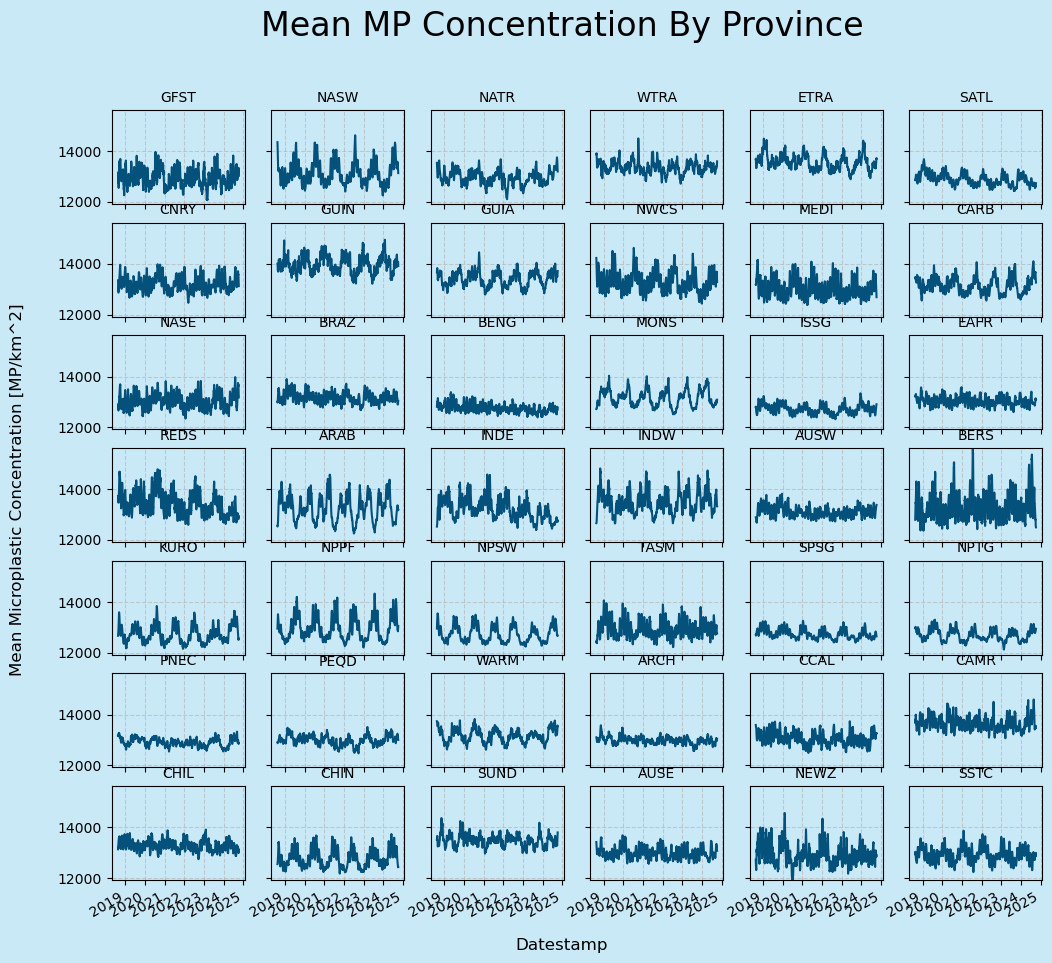

In [25]:
# Determine global y-axis limits across all 'mean' values in the data
y_min = filtered_df['mean'].apply(min).min()
y_max = filtered_df['mean'].apply(max).max()

# generate and format subplot figure
row, col = 7, 6
fig, axs = plt.subplots(row, col, figsize=(12, 10), sharex=True, sharey=True)  # Enable shared axes
fig.suptitle("Mean MP Concentration By Province", fontsize=24)
fig.patch.set_facecolor("#CAE9F7")

for i, (_, prov) in enumerate(filtered_df.iterrows()):
    ax = axs.flat[i]
    ax.plot(cygnss_data.time.values, prov['mean'], color='#04527C')
    ax.set_title(prov['ProvCode'], fontsize=10)
    ax.set_ylim(y_min, y_max)  # Set consistent y-axis limits
#     ax.yaxis.set_ticks(np.linspace(1.25*y_min, 0.75*y_max,3))
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_facecolor("#CAE9F7")

# Rotate x-axis labels for the bottom row of subplots
for ax in axs[-1, :]:  # Access the last row of axes
    for label in ax.get_xticklabels():
        label.set_rotation(30)
        label.set_ha("right")


# Add shared x and y labels for the entire figure
fig.text(0.5, 0.04, "Datestamp", ha="center", fontsize=12)
fig.text(0.04, 0.5, "Mean Microplastic Concentration [MP/km^2]", va="center", rotation="vertical", fontsize=12)

plt.show()


### Load Libraries for Modeling

In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from prophet import Prophet
from datetime import datetime, timedelta
from prophet.diagnostics import cross_validation, performance_metrics
import itertools


### Fit Model for Each Region

In [27]:
try:
    with open('model_dict2.pkl', 'rb') as handle:
        model_dict = pickle.load(handle)
except:
    model_dict = {}

    for _, prov in filtered_df.iterrows():
        # Create DataFrame in Prophet format
        prophet_df = pd.DataFrame({
                                    'ds': cygnss_data.time.values,
                                    'y':  prov['mean']
                                 })

        cutoffs = pd.to_datetime(['2020-01-01', '2021-01-01', '2022-01-01'])

        param_grid = {  
            'changepoint_prior_scale': [0.0001, 0.001, 0.01, 0.1],
            'seasonality_prior_scale': [0.001, 0.01, 0.1, 1.0],
        }

        # Generate all combinations of parameters
        all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
        rmses = []  # Store the RMSEs for each params here

        # Use cross validation to evaluate all parameters
        for params in all_params:
            m = Prophet(**params).fit(prophet_df)  # Fit model with given params
            df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
            df_p = performance_metrics(df_cv, rolling_window=1)
            rmses.append(df_p['rmse'].values[0])

        # get the best parameters with the lowest rmse
        best_params = all_params[np.argmin(rmses)]
        best_params

    #     # Find the best parameters
    #     tuning_results = pd.DataFrame(all_params)
    #     tuning_results['rmse'] = rmses
    #     print(tuning_results)

        # Initialize and fit the Prophet model
        model_dict[prov.ProvCode] = Prophet(
                                            yearly_seasonality=True,
                                            weekly_seasonality=True,
                                            daily_seasonality=False,
                                            **best_params
    #                                         changepoint_prior_scale=0.05,  # Flexibility of trend changes
    #                                         seasonality_prior_scale=10,    # Flexibility of seasonality
                                        )
        model_dict[prov.ProvCode].fit(prophet_df)

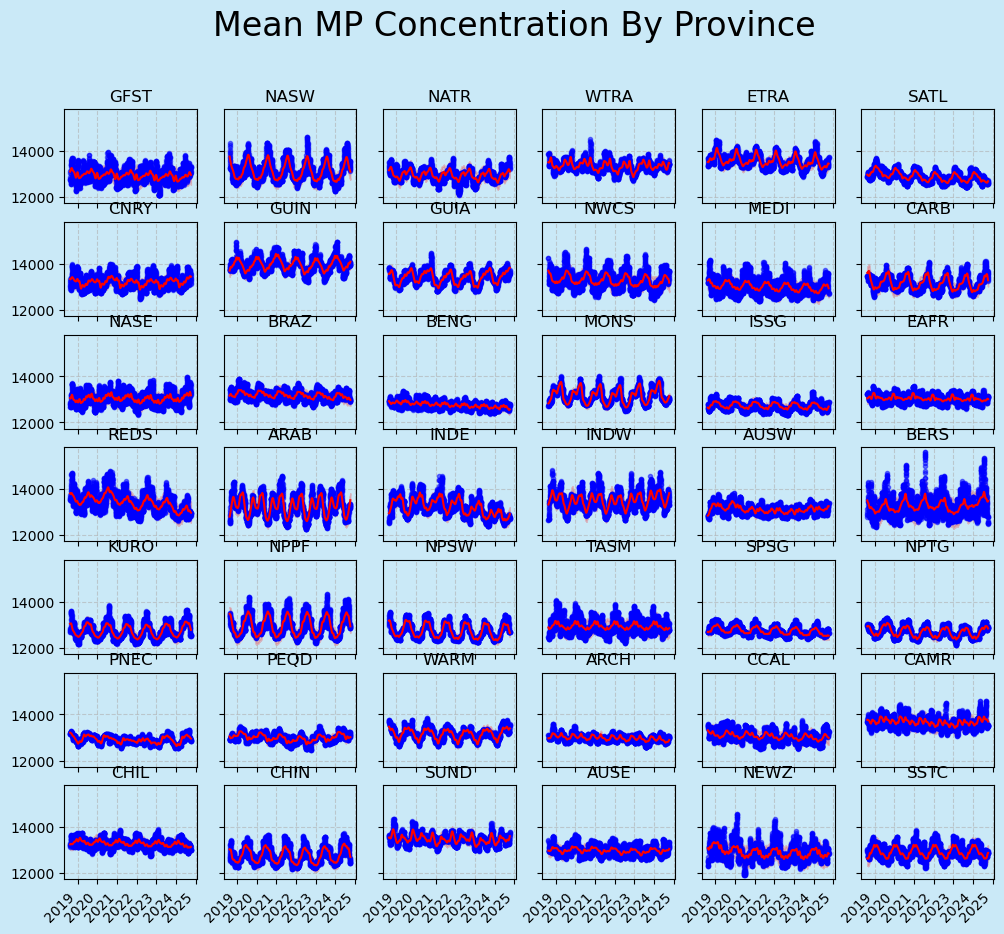

In [28]:
# latest_date = prophet_df['ds'].max()
# one_year_ago = latest_date - pd.DateOffset(years=1)

# # Create a dataframe for the backcast period
# historical_dates = pd.date_range(
#     start=one_year_ago,
#     end=latest_date,
#     freq='D'
# )
# historical_df = pd.DataFrame({'ds': historical_dates})

# generate and format subplot figure
row, col = 7,6
fig, axs = plt.subplots(row, col, figsize=(12, 10), sharex=True, sharey=True)  # Enable shared axes
fig.suptitle("Mean MP Concentration By Province", fontsize=24)
fig.patch.set_facecolor("#CAE9F7")

for i, (prov, model) in enumerate(model_dict.items()):
    
    prophet_df = pd.DataFrame({
                                    'ds': cygnss_data.time.values,
                                    'y':  filtered_df[filtered_df['ProvCode'] == prov]['mean'].values[0]
                                 })
    
    # Generate predictions
    backcast = model.predict(prophet_df)

    # Get actual values for comparison
#     actual_data = prophet_df[prophet_df['ds'] >= one_year_ago].copy()
    actual_data = prophet_df

    # Merge predictions with actual data
    comparison = pd.merge(
        backcast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
        actual_data,
        on='ds',
        how='left'
    )

#     plt.figure(figsize=(15, 8))
    ax = axs.flat[i]
    ax.set_facecolor("#CAE9F7")
        
    # Plot actual values
    ax.plot(comparison['ds'], comparison['y'], 'b.', 
            label='Actual Values', alpha=0.5)

    # Plot predicted values
    ax.plot(comparison['ds'], comparison['yhat'], 'r-', 
            label='Prophet Backcast')

    # Plot confidence intervals
    ax.fill_between(
        comparison['ds'],
        comparison['yhat_lower'],
        comparison['yhat_upper'],
        color='r',
        alpha=0.2,
        label='Confidence Interval'
    )
    ax.set_title(prov)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_facecolor("#CAE9F7")
#     ax.title('Prophet Backcast vs Actual Values - Last Year')
#     plt.legend()
#     plt.grid(True)
#     ax.set_xticks(rot=45)
#     plt.tight_layout()
#     plt.show()

# Rotate x-axis labels for the bottom row of subplots
for ax in axs[-1, :]:  # Access the last row of axes
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha("right")  # Align the labels to the right for better readability


### Join MP data to Savoca and Longurst Polygons

In [29]:
filtered_df

,mean,median,std,ProvCode
0,"[13154.5205, 13050.786, 12861.714, 12802.68, 1...","[13026.948, 12940.222, 12672.045, 12627.126, 1...","[486.53815, 493.23563, 556.14716, 547.8448, 52...",GFST
1,"[14359.373, 14266.317, 14168.504, 14053.972, 1...","[14379.951, 14248.299, 14121.833, 13995.798, 1...","[666.4824, 664.47266, 637.2081, 602.5007, 608....",NASW
2,"[13542.371, 13510.258, 13463.988, 13410.905, 1...","[13514.954, 13495.38, 13457.4375, 13415.717, 1...","[416.2826, 407.1931, 409.5267, 403.1756, 404.4...",NATR
3,"[13868.221, 13866.623, 13874.723, 13898.819, 1...","[13646.158, 13645.677, 13681.869, 13725.515, 1...","[832.3508, 813.353, 810.85065, 812.9241, 836.4...",WTRA
4,"[13692.601, 13710.975, 13703.186, 13661.056, 1...","[13635.787, 13656.321, 13638.697, 13605.748, 1...","[595.6204, 597.10266, 591.9763, 565.4013, 541....",ETRA
5,"[12861.415, 12872.765, 12888.363, 12900.2295, ...","[12839.993, 12851.982, 12872.821, 12886.625, 1...","[268.29996, 271.62698, 273.54886, 280.4534, 28...",SATL
6,"[13351.869, 13260.669, 13144.64, 13060.0, 1301...","[13206.308, 13153.692, 13040.445, 12978.766, 1...","[573.0755, 490.6029, 420.4381, 415.62177, 434....",CNRY
7,"[14010.337, 13970.553, 13941.722, 13902.539, 1...","[13885.9375, 13835.084, 13801.53, 13754.1875, ...","[820.6399, 792.44794, 811.71075, 823.5238, 826...",GUIN
8,"[13671.145, 13730.748, 13764.726, 13773.954, 1...","[13570.064, 13630.763, 13701.962, 13691.387, 1...","[936.75806, 953.5369, 963.9417, 985.8951, 1042...",GUIA
9,"[14237.641, 14229.613, 14110.575, 13952.016, 1...","[14122.946, 14167.468, 14099.944, 14020.211, 1...","[781.22687, 806.4925, 773.4135, 749.0714, 701....",NWCS


In [30]:
cygnss_df = cygnss_df.rename(columns={'Oceanographic province': 'ProvCode'})
cygnss_df.columns

Index(['Scientific name', 'Common name', 'Order', 'Family', 'Trophic level',
       'Num. w plastic', 'Total num. sampled', 'FO of plastic',
       'Mean num particles per indv', 'Habitat', 'Average depth found',
       'Primary foraging behavior', 'Commercial status', 'Aquaculture status',
       'Recreational status', 'IUCN status', 'Vulnerability score', 'ProvCode',
       'Year of collection', 'Publication year', 'Reference',
       'Quantified microplastic', 'Method type', 'Marine/estuarine',
       'Equipment used', 'Capture purpose', 'Polymer confirmation',
       'Blanks used', 'Clean lab procedures used', 'parsed_date', 'Risk_0_3',
       'Risk_0_5', 'Risk_0_10', 'Risk_0pt5_5', 'Risk_0pt5_10', 'Risk_1_5',
       'Risk_1_10', 'Risk_3_10', 'Risk_5_10'],
      dtype='object')

In [31]:
# create full dataframe that has mp data by region joined
full_df = cygnss_df.join(filtered_df.set_index('ProvCode'), on='ProvCode', how='left')
full_df

,Scientific name,Common name,Order,Family,Trophic level,Num. w plastic,Total num. sampled,FO of plastic,Mean num particles per indv,Habitat,...,Risk_0_10,Risk_0pt5_5,Risk_0pt5_10,Risk_1_5,Risk_1_10,Risk_3_10,Risk_5_10,mean,median,std
0,Platicephalus indicus,Bartail flathead,Scorpaeniformes,Platycephalidae,3.6,8.0,12.0,0.666667,2.30000,reef-associated,...,1,1,1,1,1,0,0,"[13739.208, 13661.801, 13546.145, 13558.354, 1...","[13679.781, 13594.963, 13491.888, 13486.603, 1...","[607.21356, 613.9595, 619.6748, 643.67896, 630..."
1,Saurida tumbil,Greater lizardfish,Aulopiformes,Synodontidae,4.4,4.0,4.0,1.000000,2.80000,reef-associated,...,1,1,1,1,1,0,0,"[13739.208, 13661.801, 13546.145, 13558.354, 1...","[13679.781, 13594.963, 13491.888, 13486.603, 1...","[607.21356, 613.9595, 619.6748, 643.67896, 630..."
2,Sillago sihama,Silver sillago,Perciformes,Sillaginidae,3.3,17.0,17.0,1.000000,1.50000,reef-associated,...,1,1,1,1,1,0,0,"[13739.208, 13661.801, 13546.145, 13558.354, 1...","[13679.781, 13594.963, 13491.888, 13486.603, 1...","[607.21356, 613.9595, 619.6748, 643.67896, 630..."
3,Cynoglossus abbreviatus,Three-lined tounge sole,Pleuronectiformes,Cynoglossidae,3.5,11.0,11.0,1.000000,2.90000,demersal,...,1,1,1,1,1,0,0,"[13739.208, 13661.801, 13546.145, 13558.354, 1...","[13679.781, 13594.963, 13491.888, 13486.603, 1...","[607.21356, 613.9595, 619.6748, 643.67896, 630..."
4,Galeus melastomus,Blackmouth catshark,Carcharhiniformes,Scyliorhinidae,4.2,21.0,125.0,0.168000,0.05712,demersal,...,1,0,0,0,0,0,0,"[13182.501, 13174.847, 13168.258, 13175.923, 1...","[13105.342, 13125.133, 13106.992, 13105.703, 1...","[515.61066, 494.79132, 476.9819, 506.68256, 50..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
680,Centroberyx lineatus,Swallow-tail,Beryciformes,Berycidae,4.2,3.0,3.0,1.000000,2.83000,benthopelagic,...,1,1,1,1,1,0,0,"[12549.196, 12554.352, 12574.218, 12611.333, 1...","[12502.177, 12516.598, 12556.095, 12587.734, 1...","[232.25551, 231.51848, 241.19394, 244.2859, 24..."
681,Chlorophthalmus agassizi,Shortnose greeneye,Aulopiformes,Chlorophthalmidae,3.7,1.0,1.0,1.000000,1.88000,bathydemersal,...,1,1,1,1,1,0,0,"[12549.196, 12554.352, 12574.218, 12611.333, 1...","[12502.177, 12516.598, 12556.095, 12587.734, 1...","[232.25551, 231.51848, 241.19394, 244.2859, 24..."
686,Neoscopelus microchir,shortfin neoscopelid,Myctophiformes,Neoscopelidae,3.2,1.0,1.0,1.000000,3.78000,bathypelagic,...,1,1,1,1,1,1,0,"[12549.196, 12554.352, 12574.218, 12611.333, 1...","[12502.177, 12516.598, 12556.095, 12587.734, 1...","[232.25551, 231.51848, 241.19394, 244.2859, 24..."
688,Rexea solandri,Silver gemfish,Perciformes,Gempylidae,4.3,3.0,3.0,1.000000,4.40000,benthopelagic,...,1,1,1,1,1,1,0,"[12549.196, 12554.352, 12574.218, 12611.333, 1...","[12502.177, 12516.598, 12556.095, 12587.734, 1...","[232.25551, 231.51848, 241.19394, 244.2859, 24..."


In [32]:
def augmentData(data_row, timedelta):

    # get the longhurst region for the row
    region = data_row['ProvCode']

    # calculate start date to generate data to
    end_date = data_row['parsed_date'][1]
    start_date = data_row['parsed_date'][1] - pd.Timedelta(timedelta,unit='days')

    # data needed
    date_df = pd.date_range(start=start_date, end=end_date, freq='D')

    # Create Prophet-formatted DataFrame
    df = pd.DataFrame({
        'ds': date_df
    })
    
    # predict year prior to end of data collection
    pred_df = model_dict[region].predict(df)    
    
    # calculate the sum of the data
    year_sum = pred_df['trend'].sum()
    
    return year_sum


In [33]:
# generate columns with augmented data 
full_df['mp_1yr'] = full_df.apply(augmentData, axis=1, args=(365*1,))
full_df['mp_2yr'] = full_df.apply(augmentData, axis=1, args=(365*2,))
full_df['mp_5yr'] = full_df.apply(augmentData, axis=1, args=(365*5,))

In [34]:
# define columns of interest (i.e. C.O.I.)
coi = ['Scientific name',
#         'Common name',
        'Order',
        'Family',
        'Trophic level',
        'Num. w plastic',
        'Total num. sampled',
        'FO of plastic',
        'Mean num particles per indv',
        'Habitat',
#         'Average depth found',
        'Primary foraging behavior',
        'Commercial status',
        'Aquaculture status',
        'Recreational status',
        'IUCN status',
        'Vulnerability score',
        'ProvCode',
        'Year of collection',
#         'Publication year',
#         'Reference',
#         'Quantified microplastic',
#         'Method type',
        'Marine/estuarine',
#         'Equipment used',
#         'Capture purpose',
#         'Polymer confirmation',
#         'Blanks used',
#         'Clean lab procedures used',
#         'parsed_date',
        'Risk_0_3',
        'Risk_0_5',
        'Risk_0_10',
        'Risk_0pt5_5',
        'Risk_0pt5_10',
        'Risk_1_5',
        'Risk_1_10',
        'Risk_3_10',
        'Risk_5_10',
#         'mean',
#         'median',
#         'std',
        'mp_1yr',
        'mp_2yr',
        'mp_5yr']

# define main df to perform modeling
df = full_df[coi]
df

,Scientific name,Order,Family,Trophic level,Num. w plastic,Total num. sampled,FO of plastic,Mean num particles per indv,Habitat,Primary foraging behavior,...,Risk_0_10,Risk_0pt5_5,Risk_0pt5_10,Risk_1_5,Risk_1_10,Risk_3_10,Risk_5_10,mp_1yr,mp_2yr,mp_5yr
0,Platicephalus indicus,Scorpaeniformes,Platycephalidae,3.6,8.0,12.0,0.666667,2.30000,reef-associated,Benthic foraging,...,1,1,1,1,1,0,0,5.286089e+06,1.064590e+07,2.725356e+07
1,Saurida tumbil,Aulopiformes,Synodontidae,4.4,4.0,4.0,1.000000,2.80000,reef-associated,Benthic foraging,...,1,1,1,1,1,0,0,5.286089e+06,1.064590e+07,2.725356e+07
2,Sillago sihama,Perciformes,Sillaginidae,3.3,17.0,17.0,1.000000,1.50000,reef-associated,Benthic foraging,...,1,1,1,1,1,0,0,5.286089e+06,1.064590e+07,2.725356e+07
3,Cynoglossus abbreviatus,Pleuronectiformes,Cynoglossidae,3.5,11.0,11.0,1.000000,2.90000,demersal,Benthic foraging,...,1,1,1,1,1,0,0,5.286089e+06,1.064590e+07,2.725356e+07
4,Galeus melastomus,Carcharhiniformes,Scyliorhinidae,4.2,21.0,125.0,0.168000,0.05712,demersal,Active predation,...,1,0,0,0,0,0,0,4.977441e+06,9.955747e+06,2.497732e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
680,Centroberyx lineatus,Beryciformes,Berycidae,4.2,3.0,3.0,1.000000,2.83000,benthopelagic,Active predation,...,1,1,1,1,1,0,0,4.723156e+06,9.448945e+06,2.371941e+07
681,Chlorophthalmus agassizi,Aulopiformes,Chlorophthalmidae,3.7,1.0,1.0,1.000000,1.88000,bathydemersal,Benthic foraging,...,1,1,1,1,1,0,0,4.723156e+06,9.448945e+06,2.371941e+07
686,Neoscopelus microchir,Myctophiformes,Neoscopelidae,3.2,1.0,1.0,1.000000,3.78000,bathypelagic,Particulate feeder,...,1,1,1,1,1,1,0,4.723156e+06,9.448945e+06,2.371941e+07
688,Rexea solandri,Perciformes,Gempylidae,4.3,3.0,3.0,1.000000,4.40000,benthopelagic,Active predation,...,1,1,1,1,1,1,0,4.723156e+06,9.448945e+06,2.371941e+07


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 316 entries, 0 to 689
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Scientific name              316 non-null    object 
 1   Order                        316 non-null    object 
 2   Family                       316 non-null    object 
 3   Trophic level                316 non-null    float64
 4   Num. w plastic               316 non-null    float64
 5   Total num. sampled           316 non-null    float64
 6   FO of plastic                316 non-null    float64
 7   Mean num particles per indv  316 non-null    float64
 8   Habitat                      316 non-null    object 
 9   Primary foraging behavior    316 non-null    object 
 10  Commercial status            316 non-null    object 
 11  Aquaculture status           316 non-null    object 
 12  Recreational status          316 non-null    object 
 13  IUCN status              

### Quick XGBoost Model

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Identify the target and features
target_column = 'Mean num particles per indv'
X = df.drop(columns=[target_column])
y = df[target_column]

# Identify object columns for encoding
object_columns = X.select_dtypes(include=['object']).columns

# Apply ordinal encoding to object columns
encoder = OrdinalEncoder()
X[object_columns] = encoder.fit_transform(X[object_columns])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Define and train the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = mse ** 0.5

print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 0.32760746032705396


In [37]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 316 entries, 0 to 689
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Scientific name              316 non-null    object 
 1   Order                        316 non-null    object 
 2   Family                       316 non-null    object 
 3   Trophic level                316 non-null    float64
 4   Num. w plastic               316 non-null    float64
 5   Total num. sampled           316 non-null    float64
 6   FO of plastic                316 non-null    float64
 7   Mean num particles per indv  316 non-null    float64
 8   Habitat                      316 non-null    object 
 9   Primary foraging behavior    316 non-null    object 
 10  Commercial status            316 non-null    object 
 11  Aquaculture status           316 non-null    object 
 12  Recreational status          316 non-null    object 
 13  IUCN status              

In [38]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

def train_xgboost_for_targets(df, target_columns, exclude_features=None, test_size=0.2, random_state=42):
    """
    Train XGBoost classifier for multiple target columns and evaluate performance.
    
    Parameters:
    df (pandas.DataFrame): Input dataframe
    target_columns (list): List of column names to use as targets
    exclude_features (list): List of column names to exclude from features
    test_size (float): Proportion of dataset to use for testing
    random_state (int): Random seed for reproducibility
    
    Returns:
    dict: Dictionary containing results for each target
    """
    if exclude_features is None:
        exclude_features = []
    
    results = {}
    
    for target in target_columns:
        print(f"\n{'='*50}")
        print(f"Training for target: {target}")
        print('='*50)
        
        # Prepare features and target
        X = df.drop(columns=target_columns + exclude_features)
        y = df[target]
        
        # Handle categorical variables in features
        categorical_columns = X.select_dtypes(include=['object', 'category']).columns
        for col in categorical_columns:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
        
        # Handle categorical target
        if y.dtype == 'object' or y.dtype.name == 'category':
            le = LabelEncoder()
            y = le.fit_transform(y)
        
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )

        X_val, X_test, y_val, y_test = train_test_split(
            X_test, y_test, test_size=0.5, random_state=random_state
        )
        
        # Initialize and train the model
        model = XGBClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            random_state=random_state,
            n_jobs=-1
        )
        
        # Perform cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5)
        
        # Train the final model
        model.fit(
            X_train, 
            y_train,
            eval_set=[(X_val, y_val)],
            # eval_metric='logloss',
            verbose=0
        )
        
        # Make predictions
        y_pred = model.predict(X_val)
        
        # Store results
        results[target] = {
            'model': model,
            'cv_scores': cv_scores,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'test_accuracy': accuracy_score(y_val, y_pred),
            'feature_importance': pd.DataFrame({
                'feature': X.columns,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False),
            'classification_report': classification_report(y_val, y_pred)
        }
        
        # Print results
        print(f"\nCross-validation scores: {cv_scores}")
        print(f"CV Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        print(f"\nTest set accuracy: {results[target]['test_accuracy']:.4f}")
        print("\nTop 10 important features:")
        print(results[target]['feature_importance'].head(10))
        print("\nClassification Report:")
        print(results[target]['classification_report'])
    
    return results

In [39]:
# Define target columns
target_columns = ['Risk_0_3', 'Risk_0_5', 'Risk_0_10', 'Risk_0pt5_5',
                    'Risk_0pt5_10', 'Risk_1_5', 'Risk_1_10', 'Risk_3_10', 'Risk_5_10']

exclude_features=['Mean num particles per indv', 'Num. w plastic', 'FO of plastic']

# Train models
results = train_xgboost_for_targets(df, target_columns, exclude_features=exclude_features)


Training for target: Risk_0_3

Cross-validation scores: [0.78431373 0.70588235 0.76       0.7        0.74      ]
CV Mean: 0.7380 (+/- 0.0639)

Test set accuracy: 0.7812

Top 10 important features:
               feature  importance
4   Total num. sampled    0.151053
12            ProvCode    0.071121
14    Marine/estuarine    0.066814
16              mp_2yr    0.065673
13  Year of collection    0.065128
17              mp_5yr    0.063102
15              mp_1yr    0.062470
2               Family    0.051003
5              Habitat    0.050248
3        Trophic level    0.049478

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       0.86      0.83      0.84        23
           2       0.50      0.33      0.40         3

    accuracy                           0.78        32
   macro avg       0.66      0.66      0.65        32
weighted avg       0.78      0.78      0.78        32


Training fo

In [41]:
results.keys()

dict_keys(['Risk_0_3', 'Risk_0_5', 'Risk_0_10', 'Risk_0pt5_5', 'Risk_0pt5_10', 'Risk_1_5', 'Risk_1_10', 'Risk_3_10', 'Risk_5_10'])

In [ ]:
with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(results, f)